In [1]:
import random as rd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("ggplot")
get_ipython().magic('matplotlib inline')
from math import *
import numpy as np
import pickle as pkl
import skimage as ski
from skimage.color import rgb2gray
from scipy import misc
from PIL import Image
import PIL.ImageOps
from skimage.exposure import adjust_gamma


[[ 0.09405  0.1219   0.0944 ]
 [ 0.121    0.1484   0.1163 ]
 [ 0.0944   0.1174   0.09215]]


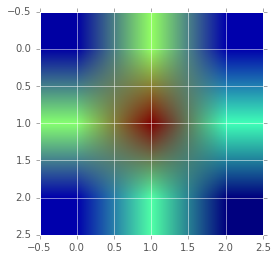

In [2]:
dict_matrix_to_num, dict_num_to_weights = pkl.load( open ("myDicts.p", "rb") )
a = dict_num_to_weights[0]
print(a)
plt.imshow(dict_num_to_weights[0])
plt.show()

In [10]:
class Cell:
    def __init__(self, pop_list, veg_type, veg_value, hum_value, iswater): #pop_list is array, veg_type is string, veg_value is the vegetation index value, hum_value is the humidity value
        self.larvae_lim_per_box = 100000
        self.pop_list  = pop_list
        self.veg_type  = veg_type
        self.veg_value = veg_value
        self.hum_value = hum_value
        self.iswater = iswater

        self.e = pop_list[0]  # e  = eggs    - aquatic steps
        self.l = pop_list[1]  # l  = larvae  - aquatic steps
        self.p = pop_list[2]  # p  = pupae   - aquatic steps

        self.ah = pop_list[3] # ah = host-seeking        adult - adult steps
        self.ar = pop_list[4] # ar = resting             adult - adult steps
        self.ao = pop_list[5] # ao = ovoposition-seeking adult - adult steps

        self.n_total   = pop_list.sum()
        self.n_aquatic = sum(pop_list[0:3])
        self.n_adult   = sum(pop_list[3:])
        
        #U for dying P for passing
        self.B = 100     #number of eggs per ovoposition
        self.PE = .50    #prob of becoming a larvae
        self.UE = .56    #prob of dying as a egg
        self.novopo = 1.3 #novopositions per day #max =1.48, maxefficient=1.4
        self.UL1 = .44   #prob of dying larvae
        self.UL2 = .1  #prob of dying due to crowding
        self.PL = 0.14   #prob of 
        self.PP = .50
        self.UP = .37
        self.PAH = .46 
        self.UAH = .18
        self.PAR = .43
        self.UAR = .0043
        self.UAO = .41
        self.PAO = .5

    def update(self):
        
        a = 0; b =1
        if self.l < self.larvae_lim_per_box: a = (1 - (self.l)/self.larvae_lim_per_box)
            
        deltae = self.PAO*self.B*self.novopo*self.ao/2  - self.e*self.UE         - self.e*self.PE     #egg value update
        deltal = self.PE*self.e    - self.l*self.UL1  - self.l*self.PL*a                            # larvae value update
        deltap = self.PL*self.l*a    - self.p*self.UP   - self.p*self.PP                            #pupae update value
        deltaah = self.PP*self.p   - self.ah*self.UAH - self.ah*self.PAH       + self.PAO*self.ao   #host-seeking update value
        deltaar = self.PAH*self.ah - self.ar*self.UAR - self.ar*self.PAR                            #resting update value
        deltaao = self.ar*self.PAR - self.PAO*self.ao - self.UAO*self.ao                            #ovoposition seeking udate value
        self.delta = [int (deltae) , int(deltal) , int(deltap) , int(deltaah) , int(deltaar) , int(deltaao)]

        self.pop_list = self.pop_list.tolist() #change from array to list as array is imutable in function
        self.e  += deltae                      # egg   value update
        self.l  += deltal                      #larvae value update
        self.p  += deltap
        self.ah += deltaah
        self.ar += deltaar
        self.ao += deltaao
        if self.e < 0  : self.e  = 0
        if self.l < 0  : self.l  = 0
        if self.p < 0  : self.p  = 0
        if self.ah < 0 : self.ah = 0
        if self.ar < 0 : self.ar = 0
        if self.ao < 0 : self.ao = 0
        self.pop_list = np.array([self.e,self.l,self.p,self.ah,self.ar, self.ao])
        self.n_total   = self.pop_list.sum()
        self.n_aquatic = sum(self.pop_list[0:3])
        self.n_adult   = sum(self.pop_list[3:])

In [85]:
class Grid:
    def __init__(self, basearray, contour, vegimage, twiimage, cityimage, pixelXmeters):
        self.shape = contour.shape
        self.contour = contour
        self.vegimage = abs(vegimage-1)
        self.twiimage = abs(twiimage-1)
        self.cityimage = cityimage
        self.pixelSize = pixelXmeters

        #initializing grid of Cells
        self.GRID = [[Cell(np.array(basearray)*abs(1-contour[j][i]), cityimage[j][i], vegimage[j][i], twiimage[j][i], contour[j][i]) for i in range(self.shape[1])] for j in range(self.shape[0])]

        #create grid of types of contour
        def neighbors_to_tuple(y,x):
            return(int(contour[y-1,x-1]), int(contour[y,x-1]), int(contour[y+1,x-1]), int(contour[y-1,x]), int(contour[y+1,x]), int(contour[y-1,x+1]), int(contour[y,x+1]), int(contour[y+1,x+1]))
        self.bordertype = [[dict_matrix_to_num[neighbors_to_tuple(j,i)] for i in range(1,self.shape[1]-1)] for j in range(1,self.shape[0]-1)]
        self.bordertype = np.pad(self.bordertype, pad_width=((1,1),(1,1)), mode='constant', constant_values=-1) #padding with zeros
        

    def getSingleGrid(self, ending):
        if ending == "e"    :  return np.array([[self.GRID[j][i].e  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "l"    :  return np.array([[self.GRID[j][i].l  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "p"    :  return np.array([[self.GRID[j][i].p  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ah"   :  return np.array([[self.GRID[j][i].ah for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ar"   :  return np.array([[self.GRID[j][i].ar for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ao"   :  return np.array([[self.GRID[j][i].ao for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "aqua" : return self.getSingleGrid("e")   + self.getSingleGrid("l") + self.getSingleGrid("p")
        if ending == "adult": return self.getSingleGrid("ah")  + self.getSingleGrid("ar")+ self.getSingleGrid("ao")
        if ending == "all"  : return self.getSingleGrid("aqua")+ self.getSingleGrid("adult")
        print("wrong command on getSingleGrid"); return np.array([[]])
        
    def grdsum(self, ending):
        grid_to_sum = self.getSingleGrid(ending)
        return grid_to_sum.sum()
        
    def update_pop(self):
        [[self.GRID[j][i].update() for i in range(self.shape[1])] for j in range(self.shape[0])]
    
    def update_migration(self):
        updatedah = np.zeros(self.shape)
        updatedao = np.zeros(self.shape)
        for i in range(1, self.shape[0]-1):
            for j in range(1, self.shape[1]-1):
                if self.GRID[i][j].iswater == 0:
                    borderMatrix = np.array(dict_num_to_weights[self.bordertype[i][j]])
                    
                    floatingah = self.GRID[i][j].ah * borderMatrix * self.vegimage[i-1:i+2,j-1:j+2]
                    if floatingah.sum() > 0.05: 
                        updatedah[i-1:i+2,j-1:j+2]   += floatingah*(self.GRID[i][j].ah/floatingah.sum())
                    else: updatedah[i-1:i+2,j-1:j+2] += self.GRID[i][j].ah * borderMatrix 
                            
                    floatingao = self.GRID[i][j].ao * borderMatrix * self.twiimage[i-1:i+2,j-1:j+2]
                    if floatingao.sum() > 0.05: 
                        updatedao[i-1:i+2,j-1:j+2]  += floatingao*(self.GRID[i][j].ao/floatingao.sum())
                    else:updatedah[i-1:i+2,j-1:j+2] += self.GRID[i][j].ao * borderMatrix
                    
        for i in range(1, self.shape[0]-1):
            for j in range(1, self.shape[1]-1):
                self.GRID[i][j].ah = updatedah[i][j]
                self.GRID[i][j].ao = updatedao[i][j]
    
    def updateall(self):
        self.update_migration()
        self.update_migration()
        self.update_migration()
        self.update_pop()
        
    def images(self):
        f, (aquatics, ah, ao, adults) = plt.subplots(ncols=4, figsize=(15,15)) # sharex=True, sharey=True
        caq = aquatics.imshow(self.getSingleGrid('aqua'), cmap=plt.get_cmap("gist_earth"))
        aquatics.set_title('Aquatics stages')
        divider1 = make_axes_locatable(aquatics)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        f.colorbar(caq,cax1)
        
        cah=ah.imshow(self.getSingleGrid('ah'), cmap=plt.get_cmap("gist_earth"))
        ah.set_title('host-seeking')
        divider2 = make_axes_locatable(ah)
        cax2 = divider2.append_axes("right", size="5%", pad=0.05)
        f.colorbar(cah,cax2)
        
        cao=ao.imshow(self.getSingleGrid('ao'), cmap=plt.get_cmap("gist_earth"))
        ao.set_title('ovoposition-seeking')
        divider3 = make_axes_locatable(ao)
        cax3 = divider3.append_axes("right", size="5%", pad=0.05)
        f.colorbar(cao,cax3)
        
        caa=adults.imshow(self.getSingleGrid('adult'), cmap=plt.get_cmap("gist_earth"))
        adults.set_title('Adult females')
        divider4 = make_axes_locatable(adults)
        cax4 = divider4.append_axes("right", size="5%", pad=0.05)
        f.colorbar(caa,cax4)

        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:]], visible=False)
        #for a in f.axes[:]: a.axis([0, self.shape[1],0, self.shape[0]])
        plt.setp([a.get_yticklabels() for a in f.axes[:]], visible=False)
        plt.tight_layout()
        plt.show()
                


In [86]:
island_shape = misc.imread("../example_images/region_border_example.png")
island_shape_gray = rgb2gray(island_shape)
island_wet = ski.img_as_float(rgb2gray(misc.imread("../example_images/TWI_example.png")))
island_veg = ski.img_as_float(rgb2gray(misc.imread("../example_images/vegetation_index_example.png")))
island_city = rgb2gray(misc.imread("../example_images/city_delimitation_example.png"))

In [87]:
%%time
mosquitos = Grid([100,100,100,100,100,100], island_shape_gray, island_veg, island_wet, island_city, 68)
for i in range(-15,15):
    for j in range(-15,15):
        mosquitos.GRID[280+i][140+j].ao = 800
        mosquitos.GRID[200+i][200+j].ah = 800
        mosquitos.GRID[320+i][330+j].ao = 400
        mosquitos.GRID[100+i][300+j].ah = 400


Wall time: 4.28 s


In [88]:
#%time mosquitos.update_pop()


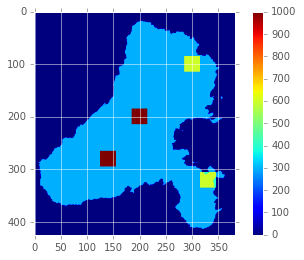

In [ ]:
plt.imshow(mosquitos.getSingleGrid("adult"))
plt.colorbar()
plt.show()

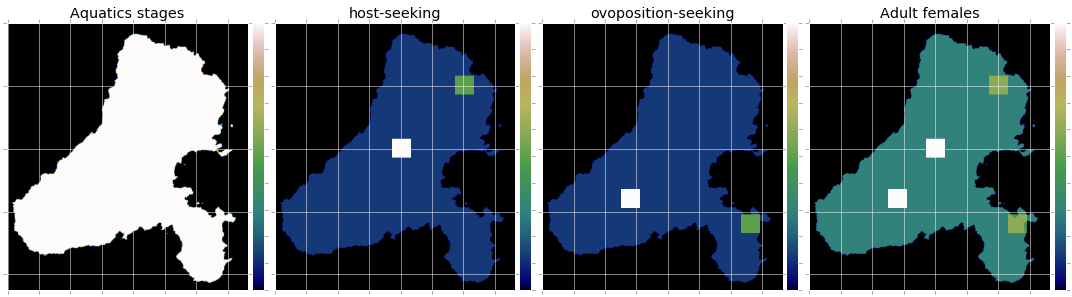

In [ ]:
mosquitos.grdsum("all")
%time mosquitos.images()
%time for i in range(30): mosquitos.updateall()
mosquitos.grdsum("all")

In [ ]:
mosquitos.images()

In [ ]:
plt.imshow(mosquitos.getSingleGrid("ah"))
print(mosquitos.grdsum('ah'))
plt.colorbar()
plt.show()

In [ ]:
print(dict_num_to_weights[0])
print(dict_matrix_to_num[(1,1,1,0,0,0,0,0)])
print(dict_num_to_weights[224])
a = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        if j!= 0: a[i][j] = 1
print(a)
print((dict_num_to_weights[0]*a).sum())
print((dict_num_to_weights[0]*a)/(dict_num_to_weights[0]*a).sum() - dict_num_to_weights[224])

In [ ]:
b4 = test.n_adult
test.update()
after = test.n_adult
conta = 0
while abs(b4-after) > 0.002*b4: 
    b4 = after
    test.update()
    after = test.n_adult
    conta += 1
    if conta%50 ==0 : print([int(i) for i in test.pop_list])
    if conta%100 ==0 : print(conta)
    if conta == 1000: break
print(conta)

In [ ]:
test = Cell(np.array([10,10,10,10,10,10]),1,1,1,1)
ovo = [test.e]
larva= [test.l]
pupa= [test.p]
ahlist= [test.ah]
arlist= [test.ar]
aolist= [test.ao]
for i in range(1000):
    test.update()
    ovo    += [test.e]
    larva  += [test.l]
    pupa   += [test.p]
    ahlist += [test.ah]
    arlist += [test.ar]
    aolist += [test.ao]

#plt.plot(range(len(ovo)), ovo, label = 'egg')
plt.plot(range(len(ovo)), larva, label = 'larvae')
#plt.plot(range(len(ovo)), pupa, label = 'pupae')
plt.plot(range(len(ovo)),ahlist, label = 'ah')
plt.plot(range(len(ovo)), arlist, label = 'ar')
plt.plot(range(len(ovo)), aolist, label = 'ao')
plt.legend()
plt.show()